# Accelerating parallel code with PyCOMPSs and Numba

## Demo Supercomputing 2019

What is mandelbrot?

The mandelbrot set is a fractal, which is plotted on the complex plane. It shows how intrincate can be formed from a simple equation.

It is generated using the algorithm:

\begin{align}
Z_{n+1} & = z_{n}^2 + A \\
\end{align}

Where *Z* and *A* are complex numbers, and *n* represents the number of iterations.

First, import time to measure the elapsed execution times and create an ordered dictionary to keep all measures -> we are going to measure and plot the performance with different conditions!

In [1]:
import time
from collections import OrderedDict
times = OrderedDict()

And then, all required imports

In [2]:
from numpy import NaN, arange, abs, array

Mandelbrot set implementation:

In [3]:
def mandelbrot(a, max_iter):
    z = 0
    for n in range(1, max_iter):
        z = z**2 + a
        if abs(z) > 2:
            return n
    return NaN

In [4]:
def mandelbrot_set(y, X, max_iter):
    Z = [0 for _ in range(len(X))]
    for ix, x in enumerate(X):
        Z[ix] = mandelbrot(x + 1j * y, max_iter)
    return Z

Main function to generate the mandelbrot set. It splits the space in vertical chunks, and calculates the mandelbrot set of each one, generating the result *Z*.

In [5]:
def run_mandelbrot(X, Y, max_iter):
    st = time.time()
    Z = [[] for _ in range(len(Y))]
    for iy, y in enumerate(Y):
        Z[iy] = mandelbrot_set(y, X, max_iter)
    elapsed = time.time() - st
    print("Elapsed time (s): {}".format(elapsed))
    return Z, elapsed

The following function plots the fractal inline (the coerced parameter *<Boolean\>* is used to set *NaN* in coerced elements within *Z*).

In [6]:
%matplotlib inline
def plot_fractal(Z, coerced):
    if coerced:
        Z = [[NaN if c == -2**63 else c for c in row] for row in Z]
    import matplotlib.pyplot as plt
    Z = array(Z)
    plt.imshow(Z, cmap='plasma')
    plt.show()

Define a benchmarking function:

In [7]:
def generate_fractal(coerced=False):
    X = arange(-2, .5, .01)
    Y = arange(-1.0,  1.0, .01)
    max_iterations = 2000
    Z, elapsed = run_mandelbrot(X, Y, max_iterations)
    plot_fractal(Z, coerced)
    return elapsed

Run the previous code **sequentially**:

Elapsed time (s): 28.323102712631226


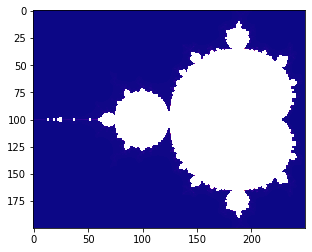

In [8]:
times['Sequential'] = generate_fractal()

## Paralellization with PyCOMPSs

After analysing the code, each mandelbrot set can be considered as a task, requiring only to decorate the ``mandelbrot_set`` function. It is interesting to observe that all sets are independent among them, so they can be computed completely independently, enabling to exploit multiple resources concurrently.

In order to run this code with we need first to start the **COMPSs** runtime:

In [9]:
import os
import pycompss.interactive as ipycompss
if 'BINDER_SERVICE_HOST' in os.environ:
    ipycompss.start(project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')
else:
    ipycompss.start(graph=False, trace=True, monitor=1000)

********************************************************
**************** PyCOMPSs Interactive ******************
********************************************************
*          .-~~-.--.           ______         ___      *
*         :         )         |____  \       /   |     *
*   .~ ~ -.\       /.- ~~ .      __) |      /_/| |     *
*   >       `.   .'       <     |__  |         | |     *
*  (         .- -.         )   ____) |   _     | |     *
*   `- -.-~  `- -'  ~-.- -'   |______/  |_|    |_|     *
*     (        :        )           _ _ .-:            *
*      ~--.    :    .--~        .-~  .-~  }            *
*          ~-.-^-.-~ \_      .~  .-~   .~              *
*                   \ \ '     \ '_ _ -~                *
*                    \`.\`.    //                      *
*           . - ~ ~-.__\`.\`-.//                       *
*       .-~   . - ~  }~ ~ ~-.~-.                       *
*     .' .-~      .-~       :/~-.~-./:                 *
*    /_~_ _ . - ~              

It is necessary to decorate the ``mandelbrot_set`` function with the ``@task`` decorator.

Note that the ``mandelbrot_set`` function returns a list of elements.

In [10]:
from pycompss.api.task import task

In [11]:
@task(returns=list)
def mandelbrot_set(y, X, max_iter):
    Z = [0 for _ in range(len(X))]
    for ix, x in enumerate(X):
        Z[ix] = mandelbrot(x + 1j * y, max_iter)
    return Z

And finally, include the synchronization of ``Z`` with ``compss_wait_on``.

In [12]:
from pycompss.api.api import compss_wait_on

In [13]:
def run_mandelbrot(X, Y, max_iter):
    st = time.time()
    Z = [[] for _ in range(len(Y))]
    for iy, y in enumerate(Y):
        Z[iy] = mandelbrot_set(y, X, max_iter)
    Z = compss_wait_on(Z)
    elapsed = time.time() - st
    print("Elapsed time (s): {}".format(elapsed))
    return Z, elapsed

Run the benchmark with **PyCOMPSs**:

Found task: mandelbrot_set
Elapsed time (s): 15.903970718383789


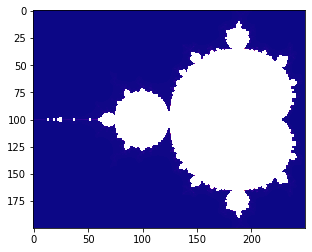

In [14]:
times['PyCOMPSs'] = generate_fractal()

## Accelerating the tasks with Numba

To this end, it is necessary to either use:
1. the Numba's ``@jit`` decorator under the PyCOMPSs ``@task`` decorator
2. or define the ``numba=True`` within the ``@task`` decorator.

First, we decorate the inner function (``mandelbrot``) with ``@jit`` since it is also a target function to be optimized with Numba.

In [15]:
from numba import jit

@jit
def mandelbrot(a, max_iter):
    z = 0
    for n in range(1, max_iter):
        z = z**2 + a
        if abs(z) > 2:
            return n
    return NaN # NaN is coerced by Numba

*Option 1* - Add the ``@jit`` decorator explicitly under ``@task`` decorator

*Option 2* - Add the ``numba=True`` flag within ``@task`` decorator

In [16]:
@task(returns=list, numba=True)
def mandelbrot_set(y, X, max_iter):
    Z = [0 for _ in range(len(X))]
    for ix, x in enumerate(X):
        Z[ix] = mandelbrot(x + 1j * y, max_iter)
    return Z

Run the benchmark with **Numba**:

Found task: mandelbrot_set
Elapsed time (s): 10.109647274017334


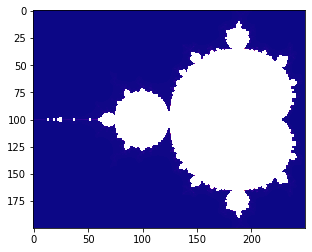

In [17]:
times['PyCOMPSs + Numba'] = generate_fractal(coerced=True)

Plot the times:

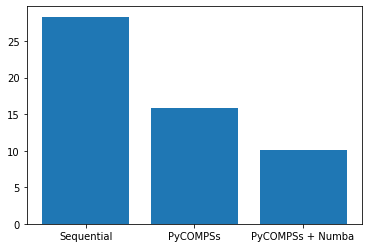

In [18]:
import matplotlib.pyplot as plt
plt.bar(*zip(*times.items()))
plt.show()

Stop **COMPSs** runtime

In [19]:
ipycompss.stop()

********************************************************
*************** STOPPING PyCOMPSs ******************
********************************************************
Checking if any issue happened.
         have not been brought to the master.
********************************************************
